This is test task for MMD Smart done by Karina Chumak.<br>
Task: create spam/not-spam classificator using DL and clustering, provide exploratory data analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')
figsize = (15,5)

In [2]:
X = pd.read_csv('data/processed_CDR_TEXT_labels.csv')

# 2. Deep Learning

For this task CNN with two channels of word embeddings was implemented, one - static, one - non-static.
This model architecture was described in Yoon Kim [paper](https://www.aclweb.org/anthology/D14-1181). I selected this model, because Weicheng Zhang, who compared LSTM and CNN in his [dissertation](http://weichengzhang.co/src/paper/Capstone_final_report.pdf), stated that CNN outperforms LSTM, even without word embeddings. Moreover, this architecture is quite simple,and performs remarkably well even with little hyperparameter tuning

In [3]:
from keras.models import Model,Sequential
from keras.layers import MaxPooling2D,Flatten,Convolution2D,Reshape,Concatenate,concatenate, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.initializers import Constant

Using TensorFlow backend.


Splitting data for train and test set

In [4]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X['CDR_TEXT'],X['labels'],test_size=0.2)

Using GloVe as word embeddings. The dimension of embedding was chosen as 50. Maximum number of words in embeddings is 200000, maximum length of sequence created from text is 100

In [5]:
GLOVE_FILE = 'data/glove.6B/glove.6B.50d.txt'
MAX_SEQUENCE_LENGTH = 100 #the longest sequence is actually 89 words
MAX_NUM_WORDS = 200000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2

In [6]:
# tokenization, sequence forming, aequence padding
tok = Tokenizer(num_words=MAX_NUM_WORDS)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [7]:
embeddings_index = {}
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [8]:
word_index = tok.word_index

In [9]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [11]:
sequence_input1 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# static embedding layer
embedded1 = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(sequence_input1)
# trainable embedding layer
embedded2 = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)(sequence_input1)
merged = concatenate([embedded1,embedded2],axis = -1)
x = Reshape((2, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))(merged)
x = Convolution2D(64, 5, activation="relu", data_format = "channels_first",border_mode='same')(x)
x = MaxPooling2D(5)(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
preds = Dense(2, activation="softmax")(x)
model = Model(inputs=sequence_input1, outputs=preds)

In [12]:
model.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['acc'])

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 50)      6605650     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 50)      6605650     input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 100, 100)     0           embedding_3[0][0]                
                                                                 embedding_4[0][0]                
__________

In [14]:
# save the weights on each epoch
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
# stop early if accuracy doesn't improve
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.0001)
# define tensorboard for model diagnosis
tensorboard = TensorBoard(log_dir='tensorboard/', histogram_freq=0,  
          write_graph=True)
callbacks_list = [checkpoint,early_stop,tensorboard]

In [15]:
# creating one hot vector for labels
from keras.utils import to_categorical
y_binary = to_categorical(np.asarray(Y_train))

In [17]:
model.fit(sequences_matrix,y_binary,batch_size=128,epochs=5,
          validation_split=0.2,callbacks=callbacks_list)

Train on 630064 samples, validate on 157516 samples
Epoch 1/5
630064/630064 [==============================] - 14947s 24ms/step - loss: 0.0057 - acc: 0.9986 - val_loss: 0.0036 - val_acc: 0.9994

Epoch 00001: loss improved from inf to 0.00567, saving model to weights-improvement-01-0.0057-bigger.hdf5
Epoch 2/5
630064/630064 [==============================] - 14965s 24ms/step - loss: 0.0035 - acc: 0.9993 - val_loss: 0.0041 - val_acc: 0.9994

Epoch 00002: loss improved from 0.00567 to 0.00346, saving model to weights-improvement-02-0.0035-bigger.hdf5


Even after first epoch model had validation accuracy 99.94%, which did not impove after 2d epoch,so the model stopped early. Let's check how it works on test set


In [18]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [19]:
y_pred = model.predict(test_sequences_matrix)

The output of the model is one-hot vector. The second column is pobability of being a spam. We'll use threshold of 0.5

In [20]:
y_pred = (pd.Series(y_pred[:,1]) > 0.5) * 1

In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,confusion_matrix

In [29]:
prec = precision_score(Y_test,y_pred, average="macro")
rec = recall_score(Y_test,y_pred, average="macro")
acc = accuracy_score(Y_test,y_pred)
print('CNN + 2 word embeddings')
print('Precision:{}'.format(prec))
print('Recall:{}'.format(rec))
print('Accuracy:{}'.format(acc))

CNN + 2 word embeddings
Precision:0.9979421483491401
Recall:0.997741017494995
Accuracy:0.9992889647326507


So the results are pretty good,taking to the account the simplicity of the model and absence of hyperparameter tuning. Let's build a confusion matrix to see, where our model makes mistakes

In [25]:
conf_matrix = confusion_matrix(Y_test, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

Text(0.5, 15.0, 'Predicted label')

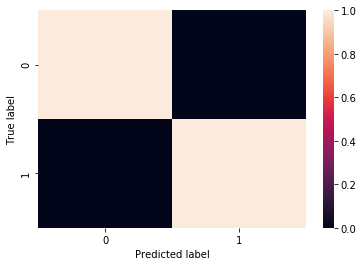

In [26]:
sns.heatmap(conf_matrix_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [27]:
print(conf_matrix)

[[178996     66]
 [    74  17760]]


<b>0 - normal, 1 - spam</b>
<br>74 out of 17834 spam letters were marked as normal 
<br>66 out of 179062 normal letters were marked as spam
<br> This model is making 1 type mistakes less, than 2 type, which is good, because marking normal letter as spam is more undesirable than the other way

In [28]:
model.save('CNN_2-epoch.h5')